In [1]:
import librosa 
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import glob

import pandas as pd
import numpy as np
import os

In [2]:
from google.colab import files 
!pip install -q kaggle

In [3]:
uploaded = files.upload()

KeyboardInterrupt: ignored

In [4]:
 ! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:

!kaggle datasets download -d mmoreaux/environmental-sound-classification-50

environmental-sound-classification-50.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
from zipfile import ZipFile
file_name = "/content/environmental-sound-classification-50.zip"
with ZipFile(file_name,"r") as zip:
  zip.extractall()
  print("Done")

KeyboardInterrupt: ignored

In [8]:
audio_path = '/content/audio/audio/44100/'
label_csv = '/content/esc50.csv'

In [9]:
waves = glob.glob(audio_path+'*.wav');
print(len(waves))

2000


In [10]:
df = pd.read_csv(label_csv, usecols=['filename', 'target', 'category'], index_col=['filename'])
df.head()

,target,category
filename,,
1-100032-A-0.wav,0,dog
1-100038-A-14.wav,14,chirping_birds
1-100210-A-36.wav,36,vacuum_cleaner
1-100210-B-36.wav,36,vacuum_cleaner
1-101296-A-19.wav,19,thunderstorm


In [11]:
def create_dir(dirname):
    if os.path.exists(dirname):
        pass
    else:
        os.makedirs(dirname)

In [12]:
def save_spectogram_images(audio_path,output,i,figsize=(4,4)):
    
    x, sr = librosa.load(audio_path+os.listdir(audio_path)[i])
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))



    fig = plt.figure(figsize=figsize, frameon=False) 
    ax = plt.Axes(fig, [0.,0.,1.,1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    librosa.display.specshow(Xdb, sr=16000, x_axis='time', y_axis='log')
    fig.savefig(output,dpi = 100)
    plt.close()

In [ ]:
import matplotlib
matplotlib.use("Agg")

for index,item in enumerate(waves):
    name = item.split("/")[-1]
    dirname ="./prep/" + df.loc[name].category
    create_dir(dirname)
    out_file = dirname + "/" + name.split(".wav")[0] + ".jpg"
    save_spectogram_images(audio_path,out_file,index)

print("Done")
    

In [13]:
from fastai import *
from fastai.vision import *

In [14]:
data = ImageDataBunch.from_folder('/content/prep', valid_pct=0.1, ds_tfms=get_transforms(do_flip=False, max_rotate=0.), size=224)
data.normalize()

ImageDataBunch;

Train: LabelList (1800 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
helicopter,helicopter,helicopter,helicopter,helicopter
Path: /content/prep;

Valid: LabelList (200 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
snoring,car_horn,car_horn,glass_breaking,toilet_flush
Path: /content/prep;

Test: None

In [15]:
learner_model = cnn_learner(data, models.resnet50, metrics=error_rate)

In [16]:
learner_model.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,4.032295,1.943390,0.525000,00:20
1,2.836555,1.594707,0.455000,00:19
2,2.170361,1.354054,0.380000,00:20
3,1.726229,1.276313,0.355000,00:20


In [17]:
learner_model.unfreeze()
learner_model.fit_one_cycle(4, max_lr=slice(1e-5, 1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,1.673521,3.056991,0.565000,00:22
1,1.811906,1.877715,0.410000,00:22
2,1.396160,0.751302,0.220000,00:22
3,0.969073,0.748370,0.200000,00:21


In [18]:
interp = ClassificationInterpretation.from_learner(learner_model)
%matplotlib inline

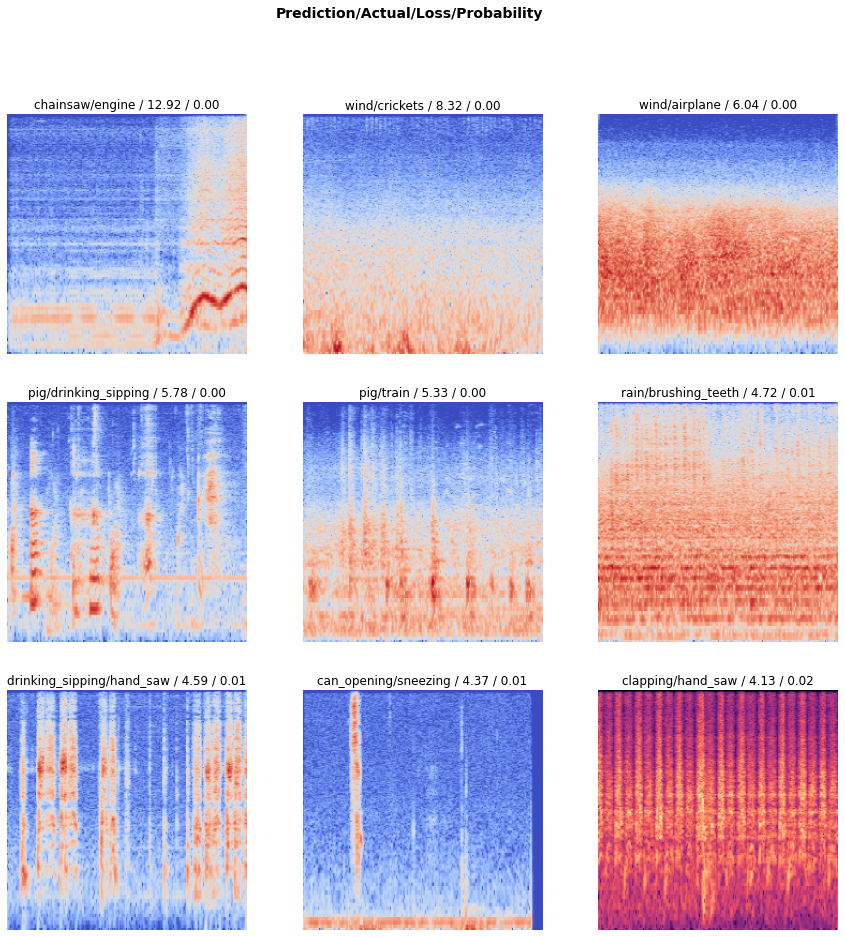

In [19]:
interp.plot_top_losses(9, figsize=(15,15))

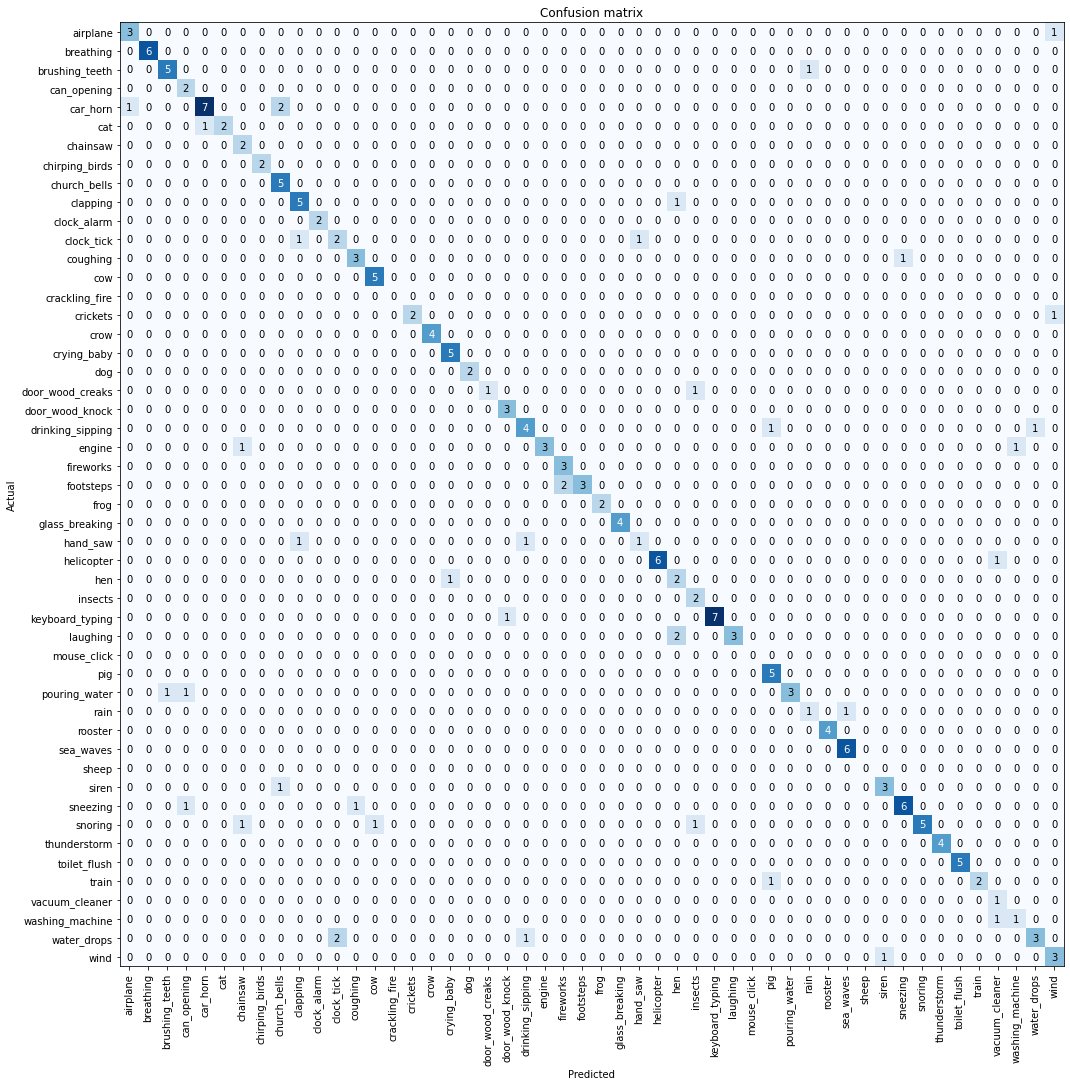

In [20]:
interp.plot_confusion_matrix(figsize=(15,15))

In [21]:
interp.most_confused(min_val=2)

[('car_horn', 'church_bells', 2),
 ('footsteps', 'fireworks', 2),
 ('laughing', 'hen', 2),
 ('water_drops', 'clock_tick', 2)]